# Build your own neos!

In [44]:
from __future__ import annotations

import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.random import PRNGKey
import pyhf
from typing import Callable, Any, Generator, Iterable
from functools import partial
import matplotlib.pyplot as plt
import neos
import relaxed

JAX_CHECK_TRACER_LEAKS = True
import h5py

jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")
import numpy as np

# matplotlib settings
plt.rc("figure", figsize=(5, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

Array = jnp.ndarray


## Preamble
`neos` tackles the problem of learning optimal summary statistics from data. The workflow is explained in more detail [in our paper]() -- this notebook is designed to get you up-and-running with how that workflow looks in code, including how to do this for your own use-case! (if you want to do that for real, please reach out -- we'd love to help you!)

To construct this kind of workflow, you need to specify three things:
- How to construct your summary statistic from data
- How to build your likelihood function from that summary statistic
- A choice of metric relating to how you deem your analysis to be "optimal"

The second bullet in-particular is very important; while we've abstracted away all the technical detail, `neos` is still not a drop-in loss function in the typical sense, since it requires *detailed information from the analyser on how to build the likelihood*. No longer do we have a problem-agnostic notion of "signal" and "background"; instead, we're wanting to optimise our specific problem, so we need to provide specific information. That is how `neos` is "systematic-aware" -- it's a technique that explicitly takes into account how your systematics are modelled. But to do this, we of course need to model them in the first place!

Here, we're going to re-implement the example from the paper with 2-dimensional Gaussian blobs making up our data. We have a nominal estimate for signal and background data, and we also provide "up" and "down" variations that correspond to moving the mean of the background blob. The helper function to generate this dataset is below:

### Dataset generation helper function + visualisation

In [45]:
w_CR = 0.007691879267891989
err_w_CR = 0.0007230248761909538
files = {}
files["SM"] = "/lustre/fs22/group/atlas/freder/hh/run/dump/dump-mc20_SM.h5"
files["k2v0"] = "/lustre/fs22/group/atlas/freder/hh/run/dump/dump-mc20_k2v0.h5"
files["ttbar"] = "/lustre/fs22/group/atlas/freder/hh/run/dump/dump-mc20_ttbar.h5"
files["run2"] = "/lustre/fs22/group/atlas/freder/hh/run/dump/dump-run2.h5"
plot_path = "/lustre/fs22/group/atlas/freder/hh/run/neos/"

do_m_hh = True
include_bins = True
vars = [
    "m_hh_NOSYS",
    "pt_hh_NOSYS",
    "eta_hh_NOSYS",
    "m_h1_NOSYS",
    "pt_h1_NOSYS",
    "eta_h1_NOSYS",
    "m_h2_NOSYS",
    "pt_h2_NOSYS",
    "eta_h2_NOSYS",
]

if do_m_hh:
    vars = ["m_hh_NOSYS"]

region = "SR_xbb_2"


def stack_inputs(filepath):
    """make matrix of input variables

    Parameters
    ----------
    filepath : str
        path to file

    Returns
    -------
    np.arrray
        matrix of input variables per event
    """
    if "run2" in filepath:
        region = "SR_xbb_1"
    else:
        region = "SR_xbb_2"

    with h5py.File(filepath, "r") as f:
        # init array
        arr = np.zeros((f[vars[0] + "." + region].shape[0], len(vars)))
        for i, var in enumerate(vars):
            # put in matrix
            arr[:, i] = f[var + "." + region][:]

        return arr


from sklearn.preprocessing import MinMaxScaler


def min_max_norm(data):
    # need to concatenate to find overall min max
    data_ = np.concatenate([data[key] for key in data.keys()])

    shapes = [data[key].shape[0] for key in data.keys()]
    shapes_cumulative = np.cumsum(shapes)

    scaler = MinMaxScaler()
    # find min max in columns
    scaler.fit(data_)
    data_min = scaler.data_min_
    data_max = scaler.data_max_
    # apply
    scaled_data = scaler.transform(data_)
    # split to original samples
    scaled_data_splitted = np.split(scaled_data, shapes_cumulative[:-1])

    for i, key in enumerate(data.keys()):
        data[key] = scaled_data_splitted[i]

    return data, data_min, data_max


def append_weights(arr, filepath, replicate_weight=1):
    if "run2" in filepath:
        region = "SR_xbb_1"
    else:
        region = "SR_xbb_2"
    with h5py.File(filepath, "r") as f:
        weights = f["weights." + region][:] * replicate_weight
        weights = weights.reshape((weights.shape[0], 1))
        arr = np.append(arr, weights, axis=1)
    return arr


def prepare_data():
    data = {
        "sig": stack_inputs(files["k2v0"]),
        # "ttbar": stack_inputs(files["ttbar"]),
        "multijet": stack_inputs(files["run2"]),
    }

    if include_bins:
        global data_min, data_max
        data, data_min, data_max = min_max_norm(data)

    print([data[key].shape[0] for key in data.keys()])

    # replicate to have same sample size as signal
    replicate_weight = 1 / (data["sig"].shape[0] / data["multijet"].shape[0])

    # I know its bad to put the weights in the data, but there is so much
    # shuffling etc happening, that it is the easiest for now
    data = {
        "sig": append_weights(data["sig"], files["k2v0"]),
        # "ttbar": append_weights(files["ttbar"]),
        "multijet": append_weights(
            data["multijet"],
            files["run2"],
            replicate_weight=replicate_weight * w_CR,
        ),
    }
    # replicate to have same size sample input
    data["multijet"] = np.asarray(np.resize(data["multijet"][:], data["sig"].shape))

    return jnp.asarray(data["sig"]), jnp.asarray(data["multijet"])


data = prepare_data()
print([x.shape for x in data])
print(data)
# print(data)


[16379, 3884]
[(16379, 2), (16379, 2)]
(DeviceArray([[ 0.13868569,  0.00083064],
             [ 0.29152089,  0.00085117],
             [ 0.15909703,  0.00084412],
             ...,
             [ 0.48188462, -0.00078336],
             [ 0.1977723 ,  0.0008654 ],
             [ 0.29612509,  0.00083203]], dtype=float64), DeviceArray([[0.12016009, 0.001824  ],
             [0.23277097, 0.001824  ],
             [0.20072826, 0.001824  ],
             ...,
             [0.19978891, 0.001824  ],
             [0.23466981, 0.001824  ],
             [0.14126024, 0.001824  ]], dtype=float64))


Now that we have our data, we need to specify how we construct our summary statistic. We will use a neural network for this, left unspecified until later. Since our likelihood modelling stage will later involve using histograms, we'll also construct a histogram of the output, then scale the yields in each batch for a more "realistic" analysis. This step is wrapped up in a simple convenience function called `neos.hists_from_nn`, which we'll use in a moment.

After this comes the problem-specific part: the likelihood model construction. I mentioned before that we have "up" and "down" datasets -- this is a typical construct in HEP that we use to model the effect of physical parameters. We will then have three histograms for the background data: one for each of the nominal, up, and down samples. The HistFactory prescription for building likelihood functions then models the uncertainty between these by interpolating between their yields. Luckily, this is done under the hood for us in `pyhf` -- we just need to write a dictionary specifying the format of our histograms. This can be found below for our case, where we describe our uncertainty by forming a nuisance parameter `"correlated_bkg_uncertainty"` that modifies the shape of the histogram in a bin-correlated fashion. 

### Physicist's input: how to build your statistical model from histograms 

In [46]:
# assume we give a dict of histograms with keys "sig", "bkg_nominal", "bkg_up",
# "bkg_down".


def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    stat_err = jnp.sqrt(hists["bkg_nominal"])

    spec = {
        "channels": [
            {
                "name": "singlechannel",  # we only have one "channel" (data region)
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],  # signal
                        "modifiers": [
                            {
                                "name": "mu",
                                "type": "normfactor",
                                "data": None,
                            },  # our signal strength modifier (parameter of interest)
                        ],
                    },
                    {
                        "name": "background",
                        "data": jnp.array(hists["bkg_nominal"]),  # background
                        "modifiers": [
                            {
                                "name": "multijet_shape_unc",
                                "type": "histosys",
                                "data": {
                                    "hi_data": jnp.array(
                                        hists["bkg_nominal"] * 1.1
                                    ),  # up sample
                                    "lo_data": jnp.array(
                                        hists["bkg_nominal"] * 0.9
                                    ),  # down sample
                                },
                            },
                            # {
                            #     "name": "multijet_stat_unc",
                            #     "type": "histosys",
                            #     "data": {
                            #         "hi_data": jnp.array(
                            #             hists["bkg_nominal"] + stat_err
                            #         ),  # up sample
                            #         "lo_data": jnp.array(
                            #             hists["bkg_nominal"] - stat_err
                            #         ),  # down sample
                            #     },
                            # },
                        ],
                    },
                    # {
                    #     "name": "ttbar",
                    #     "data": hists["ttbar"],  # background
                    #     "modifiers": [
                    #         {
                    #             "name": "ttbar_unc",
                    #             "type": "histosys",
                    #             "data": {
                    #                 "hi_data": jnp.array(
                    #                     hists["ttbar"] * 1.05
                    #                 ),  # up sample
                    #                 "lo_data": jnp.array(
                    #                     hists["ttbar"] * 0.95
                    #                 ),  # down sample
                    #             },
                    #         },
                    #     ],
                    # },
                ],
            },
        ],
    }

    return pyhf.Model(spec, validate=False)


Now we just have to form our metric of choice from our likelihood model. Here, we have a variety to choose from: uncertainty on the signal strength modifier (cross-section), discovery significance, CLs, even the classic binary cross-entropy (that doesn't use the likelihood at all). Instead of overloading the notebook with losses, I've baked them all into `neos.loss_from_model`, which takes in a `pyhf` model and a string with the metric you want to calculate.

With these ingredients, we just need to compose them in one function, so we can take the gradient of that function with respect to our free parameters:

### Build pipeline by combining functions from the `neos` module with our model builder

In [47]:
# copied here from the neos and relaxed package to keep track of changes


@partial(jax.jit, static_argnames=["density", "reflect_infinities"])
def hist(
    data: Array,
    weights: Array,
    bins: Array,
    bandwidth: float,  # | None = None,
    density: bool = False,
    reflect_infinities: bool = False,
) -> Array:
    """Differentiable histogram, defined via a binned kernel density estimate (bKDE).

    Parameters
    ----------
    data : Array
        1D array of data to histogram.
    bins : Array
        1D array of bin edges.
    bandwidth : float
        The bandwidth of the kernel. Bigger == lower gradient variance, but more bias.
    density : bool
        Normalise the histogram to unit area.
    reflect_infinities : bool
        If True, define bins at +/- infinity, and reflect their mass into the edge bins.

    Returns
    -------
    Array
        1D array of bKDE counts.
    """
    # bandwidth = bandwidth or events.shape[-1] ** -0.25  # Scott's rule
    # proof is for gaussian... and also wrong above, must be 3.49*sigma*n^(-1/3)
    # https://www.stat.cmu.edu/~rnugent/PCMI2016/papers/ScottBandwidth.pdf

    bins = jnp.array([-jnp.inf, *bins, jnp.inf]) if reflect_infinities else bins

    # 7.2.3 nathan thesis
    # get cumulative counts (area under kde) for each set of bin edges

    cdf = jsp.stats.norm.cdf(bins.reshape(-1, 1), loc=data, scale=bandwidth)
    # multiply with weights
    cdf = cdf * weights
    # sum kde contributions in each bin
    counts = (cdf[1:, :] - cdf[:-1, :]).sum(axis=1)

    if density:  # normalize by bin width and counts for total area = 1
        db = jnp.array(jnp.diff(bins), float)  # bin spacing
        counts = counts / db / counts.sum(axis=0)

    if reflect_infinities:
        counts = (
            counts[1:-1]
            + jnp.array([counts[0]] + [0] * (len(counts) - 3))
            + jnp.array([0] * (len(counts) - 3) + [counts[-1]])
        )

    return counts


def hists_from_nn(
    pars: Array,
    data: dict[str, Array],
    nn: Callable,
    bandwidth: float,
    bins: Array,
    scale_factors: dict[str, float] | None = None,
    overall_scale: float = 1.0,
) -> dict[str, Array]:
    """Function that takes in data + analysis config parameters, and constructs yields."""

    # retrieve weights
    weights = {k: data[k][:, -1] for k in data}
    # remove weights for training
    data = {k: data[k][:, :-1] for k in data}
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )

    # define our histogram-maker with some hyperparameters (bandwidth, binning)
    make_hist = partial(hist, bandwidth=bandwidth, bins=bins_new)

    # scale_factors = scale_factors or {k: 1.0 for k in nn_output}

    # apply the neural network to each data sample, and keep track of the
    # sample names in a dict
    nn_output = {k: nn(pars, data[k][:]).ravel() for k in data}
    hists = {
        k: make_hist(data=nn_output[k], weights=weights[k])
        for k, v in nn_output.items()
    }

    return hists


def hists_from_mhh(
    data: dict[str, Array],
    bins: Array,
    bandwidth: float,
    include_bins=False,
):
    # retrieve weights
    weights = {k: data[k][:, -1] for k in data}
    # remove weights for training
    data = {k: data[k][:, :-1] for k in data}
    if include_bins:
        bins = jnp.concatenate(
            (
                jnp.array([bins[0]]),
                jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
            ),
            axis=0,
        )

    make_hist = partial(hist, bandwidth=bandwidth, bins=bins)
    hists = {
        k: make_hist(data=data[k].ravel(), weights=weights[k]) for k, v in data.items()
    }

    return hists


In [48]:
def pipeline(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    loss: str,
    bandwidth: float,
    sample_names: Iterable[str],  # we're using a list of dict keys for bookkeeping!
    scale_factors: dict[str, float],
    bins: Array | None = None,  # in case you don't want to optimise binning
    lumi: float = 10.0,  # overall scale factor
    include_bins=True,
    do_m_hh=False,
) -> float:
    # zip up our data arrays with the corresponding sample names
    data_dct = {k: v for k, v in zip(sample_names, data)}

    # if you want s/b discrimination, no need to do anything complex!
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn)

    # use a neural network + differentiable histograms [bKDEs] to get the
    # yields
    if do_m_hh:
        hists = hists_from_mhh(
            data=data_dct,
            bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
            bandwidth=bandwidth,
            include_bins=include_bins,
        )
    else:
        hists = hists_from_nn(
            pars=pars["nn_pars"],
            nn=nn,
            data=data_dct,
            bandwidth=bandwidth,  # for the bKDEs
            bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
            scale_factors=scale_factors,
            overall_scale=lumi,
        )

    # build our statistical model, and calculate the loss!
    model = model_from_hists(hists)

    return neos.loss_from_model(model, loss=loss)


Below is now mostly training boilerplate! I'll add titles, but should be mostly clear what's going on (ask if not!)

### Initialise network architecture + params

In [49]:
import jax.example_libraries.stax as stax

rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

# we have one less because of weights
num_features = len(vars)
_, init = init_random_params(PRNGKey(rng_state), (-1, num_features))
init_pars = dict(nn_pars=init)


# from typing import Sequence

# import flax.linen as nn

# class MLP(nn.Module):
#   features: Sequence[int]

#   @nn.compact
#   def __call__(self, x):
#     for feat in self.features[:-1]:
#       x = nn.relu(nn.Dense(feat)(x))
#     x = nn.Dense(self.features[-1])(x)
#     return x

# model = MLP([12, 8, 4])
# batch = jnp.ones((32, 10))
# variables = model.init(jax.random.PRNGKey(0), batch)
# output = model.apply(variables, batch)


### Define batching mechanism for data

In [50]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 100_000  # change me if you want!

# X_train, X_test, y_train, y_test = train_test_split(

split = train_test_split(*data, train_size=0.8, random_state=rng_state)
train, test = split[::2], split[1::2]


def batches(training_data: Array, batch_size: int) -> Generator:
    num_train = training_data[0].shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism, ripped from the JAX docs :)
    def data_stream():
        rng = npr.RandomState(rng_state)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]

                yield [points[batch_idx] for points in train]

    return data_stream()


batch_iterator = batches(train, batch_size)


### Training loop definition


In [51]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter


def run_optimisation(
    num_steps: int,
    objective: str,
    test_objective: str,
    lr: float,
    bins: Array,
    data_types: Iterable[str],
    scales: dict[str, float],
    include_bins: bool = True,
    do_m_hh=False,
    bandwidth=0.2,
) -> tuple[Array, dict[str, list]]:
    loss = partial(
        pipeline,
        nn=nn,
        sample_names=data_types,
        scale_factors=scales,
        include_bins=include_bins,
        do_m_hh=do_m_hh,
    )

    solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

    pyhf.set_backend("jax", default=True)

    params = init_pars
    best_params = init_pars
    best_sig = 999
    metrics = {k: [] for k in ["cls", "discovery", "poi_uncert"]}
    z_a = []
    bins_per_step = []
    for i in range(num_steps):
        print(f"step {i}: loss={objective}")
        data = next(batch_iterator)
        if i == 0:
            if include_bins:
                init_pars["bins"] = bins[
                    1:-1
                ]  # don't want to float endpoints [will account for kde spill]
                state = solver.init_state(
                    init_pars, data=data, loss=objective, bandwidth=bandwidth
                )
            else:
                if "bins" in init_pars:
                    del init_pars["bins"]
                state = solver.init_state(
                    init_pars, bins=bins, data=data, loss=objective, bandwidth=bandwidth
                )

        start = perf_counter()
        params, state = solver.update(
            params, state, bins=bins, data=data, loss=objective, bandwidth=bandwidth
        )
        end = perf_counter()
        print(f"update took {end-start:.4g}s")
        if "bins" in params:
            print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
            bins_per_step.append(params["bins"])
        for metric in metrics:
            # small bandwidth to have "spikes"
            test_metric = loss(
                params, bins=bins, data=test, loss=metric, bandwidth=1e-8
            )
            print(f"{metric}={test_metric:.4g}")
            metrics[metric].append(test_metric)
        if metrics["discovery"][-1] < best_sig:
            best_params = params
            best_sig = metrics["discovery"][-1]
        # for Z_A

        if "bins" in params and do_m_hh:
            yields = hists_from_mhh(
                data={k: v for k, v in zip(data_types, data)},
                bandwidth=1e-8,
                bins=params["bins"],
            )
            this_z_a = relaxed.metrics.asimov_sig(
                s=yields["sig"], b=yields["bkg_nominal"]
            )
            print("Z_A: ", this_z_a)
            z_a.append(this_z_a)

    metrics["Z_A"] = z_a
    metrics["bins"] = bins_per_step
    return best_params, metrics


### Run!

In [52]:
# set at beginning
# include_bins = True  # simultaneously optimise binning and neural net!
num_bins = 7
# for NN
bins = jnp.linspace(0, 1, num_bins + 1)  # keep in [0,1] if using sigmoid activation
bandwidth = 0.2  # bandwidth ~ bin width
# for m_hh
if do_m_hh and not include_bins:
    bins = np.array(
        [
            -np.inf,
            500e3,
            900e3,
            1080e3,
            1220e3,
            1360e3,
            1540e3,
            1800e3,
            2500e3,
            np.inf,
        ]
    )  # rel 21 analysis
    bandwidth = 1


lr = 1e-2
num_steps = 10

# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
objective = "cls"
test_metric = "discovery"

# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal"]  # , "ttbar"]
scales = {k: 1.0 for k in data_types}

best_params, metrics = run_optimisation(
    num_steps,
    objective,
    test_metric,
    lr,
    bins,
    data_types,
    scales,
    include_bins,
    do_m_hh,
    bandwidth,
)


step 0: loss=cls
update took 4.318s
bin edges: [0  0.243 0.386 0.329 0.471 0.614 0.757  1]
cls=0.3035
discovery=nan
poi_uncert=1.056
Z_A:  1.82419045655917
step 1: loss=cls
update took 3.987s
bin edges: [0  0.19 0.328 0.262 0.501 0.514 0.658  1]
cls=0.304
discovery=0.133
poi_uncert=1.056
Z_A:  2.0236602174756295
step 2: loss=cls
update took 4.012s
bin edges: [0  0.137 0.336 0.21 0.449 0.536 0.656  1]
cls=0.3061
discovery=0.1346
poi_uncert=1.058
Z_A:  2.1496325223498816
step 3: loss=cls
update took 4.079s
bin edges: [0  0.15 0.295 0.167 0.397 0.565 0.706  1]
cls=0.2988
discovery=nan
poi_uncert=1.048
Z_A:  2.145441138691052
step 4: loss=cls
update took 3.987s
bin edges: [0  0.171 0.247 0.132 0.382 0.551 0.745  1]
cls=0.2972
discovery=0.1283
poi_uncert=1.045
Z_A:  2.0702737710058177
step 5: loss=cls
update took 3.911s
bin edges: [0  0.168 0.229 0.101 0.382 0.527 0.732  1]
cls=0.2979
discovery=nan
poi_uncert=1.045
Z_A:  2.039069554227218
step 6: loss=cls
update took 4.845s
bin edges: [0  0

## Random visualisations!

### Metrics

range(1, 11)


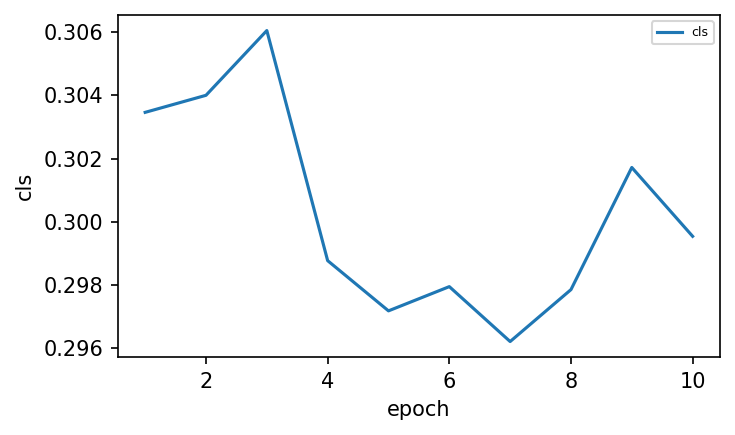

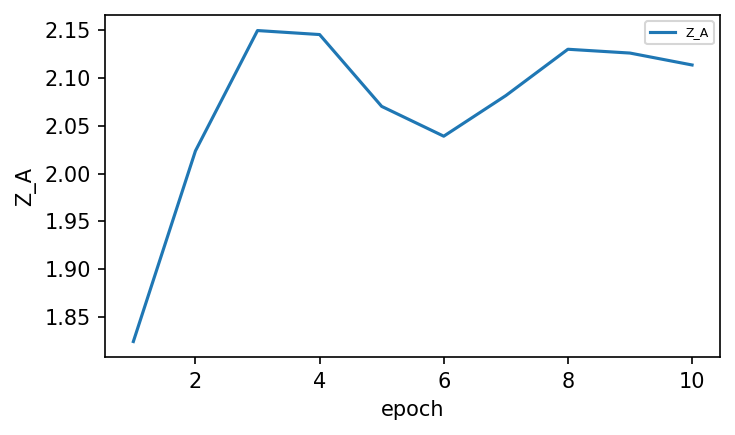

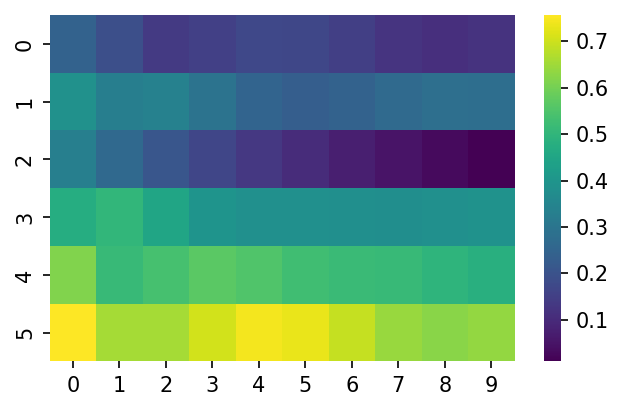

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_grid = range(1, num_steps + 1)
print(epoch_grid)
for k, v in metrics.items():
    # if k != "generalised_variance":
    if k == "cls" or k == "Z_A":
        plt.figure()
        plt.plot(epoch_grid, v, label=k)
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel(k)
        plt.tight_layout()
        plt.savefig(plot_path + k + ".pdf")
    if k == "bins":
        plt.figure()
        sns.heatmap(np.array(v).T, cmap="viridis")
# plt.yscale("log")
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("metric")
# plt.tight_layout()
# plt.savefig(plot_path + "metrics.pdf")


### Histograms

In [54]:
if include_bins:
    bins = jnp.array([0, *best_params["bins"], 1])
    print(best_params["bins"])
if do_m_hh:
    # use whole data set to get correct norm
    yields = hists_from_mhh(
        data={k: v for k, v in zip(data_types, data)},
        bandwidth=1e-8,
        bins=bins,
    )
    model = model_from_hists(yields)

    # this here gives the same cls! jay
    print(model.expected_data([0, 1.0]))

    CLs_obs, CLs_exp = pyhf.infer.hypotest(
        1.0,  # null hypothesis
        model.expected_data([0, 0.0]),
        model,
        test_stat="q",
        return_expected_set=True,
    )
    print(f"      Observed CLs: {CLs_obs:.4f}")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

    print(
        "relaxed cls: ",
        relaxed.infer.hypotest(
            test_poi=1.0,
            data=model.expected_data([0, 0.0]),
            model=model,
            test_stat="q",
            # expected_pars=hypothesis_pars,
            lr=0.002,
        ),
    )

else:
    # to get correct yields would also need to pass whole data
    yields = hists_from_nn(
        pars=best_params["nn_pars"],
        data={k: v for k, v in zip(data_types, test)},
        nn=nn,
        bandwidth=1e-8,
        bins=jnp.array([0, *best_params["bins"], 1]),
    )
print(
    bins[1:-1],
)
print(yields)
print("Asimov Significance: ", relaxed.metrics.asimov_sig(s=yields["sig"],b=yields["bkg_nominal"]))
# original Asimov Significance:  2.5999689964036663

# print(data_max)
# print(data_min)
for c, (l, a) in zip(
    ["C0", "C1", "C2", "C3"], zip(yields, jnp.array(list(yields.values())))
):
    if do_m_hh:
        if include_bins:
            bins_unscaled = (bins * (data_max - data_min)) + data_min
            print(bins_unscaled)
            plt.stairs(
                a,
                bins_unscaled,
                label=l,
                alpha=0.4,
                fill=None,
                edgecolor=c,
                linewidth=2,
            )
        else:
            plt.stairs(
                a[1:-1],
                bins[1:-1],
                label=l,
                alpha=0.4,
                fill=None,
                edgecolor=c,
                linewidth=2,
            )
        plt.xlabel("m$_{hh}$ (MeV)")
    else:
        plt.bar(
            range(len(a)), a, label=l, alpha=0.4, fill=None, edgecolor=c, linewidth=2
        )
        plt.xlabel("NN score")
plt.ylabel("Events")
plt.legend()
plt.tight_layout()
plt.savefig(plot_path + "hist.pdf")


Use the qmu_tilde test statistic (pyhf.infer.test_statistics.qmu_tilde) instead.


[0.14757893 0.24146533 0.07361264 0.37875929 0.51715762 0.69029274]
[ 15.38997579  15.85364471 -29.84406139  38.36162012   2.45746005
   0.73554961   0.13729736   0.        ]


ERROR:pyhf.optimize.mixins: message: Iteration limit reached
 success: False
  status: 9
     fun: nan
       x: [-7.628e-06  1.000e+00]
     nit: 100000
     jac: [ 1.756e+00  8.876e+00]
    nfev: 1099990
    njev: 100000
Traceback (most recent call last):
  File "/lustre/fs22/group/atlas/freder/hh/neos_env/lib/python3.9/site-packages/pyhf/optimize/mixins.py", line 62, in _internal_minimize
    assert result.success
AssertionError


FailedMinimization: Iteration limit reached